# Laboratorio di simulazione numerica

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string

### Exercise 08.2
I wrote a program to compute the expectation value of the Hamiltonian
$$
H=\frac{1}{2}p^2+x^4-\frac{5}{2}x^2
$$
on the wavefunction
$$
\psi_{\mu,\sigma}(x)\propto\exp\biggl(-\frac{(x-\mu)^2}{2\sigma^2}\biggr)+\exp\biggl(-\frac{(x+\mu)^2}{2\sigma^2}\biggr).
$$

The program reads the selected values of $\mu$ and $\sigma$ from an input file that contains, in order, those values and the width of the cell that the algorithm will use to sample the new point in the chain (so that the user can tune the parameter to reach an acceptance ratio of $1/2$).
Then, run `./exercise08-2 <input_file>` while in the `exercise08-2` directory to obtain the estimate of the expectation value, along with its standard deviation.

In the cell below, I adapted the program in order to calculate the expectation value (alone) on a grid of values, in order to plot the expectation value as a function of $\mu$ and $\sigma$ in a given area: running `./exercise08-2_grid mu_min mu_max sigma_min sigma_max N` computes the expectation value on a $N\times N$-points grid in the square $[\mu_\textrm{min},\mu_\textrm{max})\times[\sigma_\textrm{min},\sigma_\textrm{max})$, and outputs the result on the file `grid.dat`.

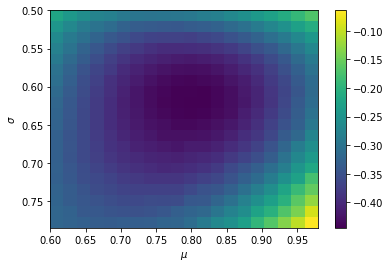

In [20]:
prefix = "exercise08-2/"
mu, sigma, energy_avg, energy_err = np.loadtxt(prefix + "grid.dat", unpack = True)

N = int(np.sqrt(len(mu)))
grid = energy_avg.reshape((N, N)).T

# In order to see the minimum more easily, and knowing it
# is negative, I clip the values in 'grid', keeping the
# negative ones only.
grid = grid.clip(None, 0)

fig, axes = plt.subplots()
im = plt.imshow(grid, extent = (mu.min(), mu.max(), sigma.max(), sigma.min()),
           interpolation = "nearest")

axes.set_xlabel(r"$\mu$")
axes.set_ylabel(r"$\sigma$")
axes.set_aspect("auto")
fig.colorbar(im)
plt.show()

Jugdging by the plot above, the minimum seems to lie close to $\mu=0.82$ and $\sigma=0.62$. These are the values I choose to compare the trial wavefunction with the numerical, exact, one, in the following plots, which I obtained running `./exercise08-2 input_minimum.dat` (as described above).

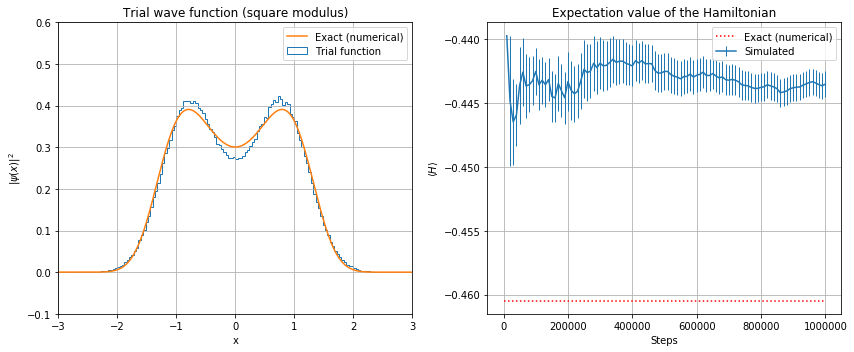

In [19]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

# Gather the data.
drawn_points = np.loadtxt(prefix + "drawn_points.dat", unpack = True)
steps, avg, err = np.loadtxt(prefix + "energy.dat", unpack = True)

# Histogram of the square modulus of the wave function.
axes[0].hist(
    drawn_points,
    bins = 200,
    range = (-4, 4),
    density = True,
    histtype = "step",
    label = "Trial function"
)
axes[0].set_title("Trial wave function (square modulus)")
axes[0].set_ylabel(r"$|\psi(x)|^2$")
axes[0].set_xlabel("x")
axes[0].grid(True)

# Expectation value of the Hamiltonian.
axes[1].errorbar(
    steps,
    avg,
    yerr = err,
    label = "Simulated",
    elinewidth = 1
)
axes[1].hlines(
    -0.46046,
    0,
    steps[-1],
    colors = "red",
    linestyle = "dotted",
    label = "Exact (numerical)"
)
axes[1].set_title("Expectation value of the Hamiltonian")
axes[1].set_ylabel(r"$\langle H\rangle$")
axes[1].set_xlabel("Steps")
axes[1].grid(True)
axes[1].legend()

# Numerical approximation of the exact probability density.
n_points = 1000 # Number of iterations
x = np.linspace(-4, 4, n_points)
dx = x[1] - x[0] # Step size

# Discrete "second derivative matrix operator": multiply a
# vector by this matrix and divide by the step size to
# obtain its discrete second derivative, calculated using
# the central differences method
# f'' = (f_1 - 2 f_0 + f_-1) / dx^2.
laplacian = np.diag(np.ones(n_points - 1), -1) - 2 * np.diag(np.ones(n_points), 0) + np.diag(np.ones(n_points - 1), 1)

# Potential energy
V = [(p**2 - 2.5) * p**2 for p in x]
# Hamiltonian matrix
H = -laplacian / (2 * dx**2) + np.diag(V)

# Compute the eigenvectors and their eigenvalues.
E, psi = np.linalg.eigh(H)

# Take the transpose, then normalize.
psi = np.transpose(psi)
psi = psi / np.sqrt(dx)

axes[0].plot(x, (psi[0])**2, label = "Exact (numerical)")
axes[0].set_xlim((-3, 3))
axes[0].set_ylim((-0.1, 0.6))
axes[0].legend()

fig.tight_layout()
plt.show()

### Exercise 08.3
##### Simulation of the ground state
The folllowing plots show the results of the *path-integral ground-state* Monte Carlo algorithm: starting from the wavefunctions (not normalised)
$$
\psi_1(x)=1,
\hspace{1cm}
\psi_2(x)=\exp\biggl(-\frac{(x-\mu)^2}{2\sigma^2}\biggr)+\exp\biggl(-\frac{(x+\mu)^2}{2\sigma^2}\biggr),
$$
the program calculates the shape of the probability density function of the ground state.
The first wavefunction is used by the `./exercise08-3_flat` executable (while in the `exercise08-3` directory), while the second by `./exercise08-3_bumps`.
The results below can be obtained running the two executables passing `input.pigs` as an argument.

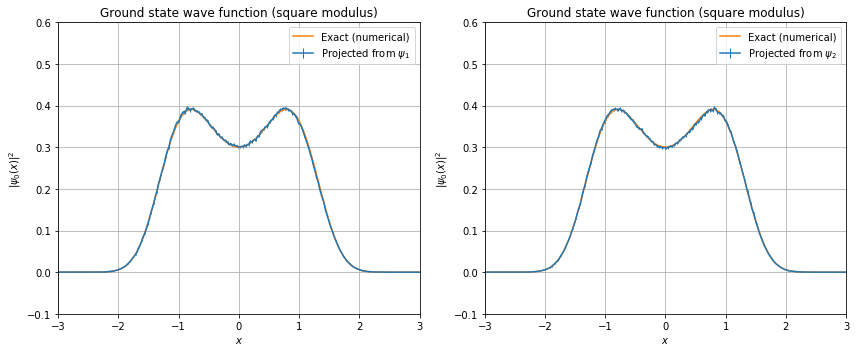

In [49]:
prefix = "exercise08-3/pigs/"

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

# Histogram of the square modulus of the wave function.
x_bins, h_avg, h_err = np.loadtxt(prefix + "probability_flat.dat", unpack = True)
axes[0].errorbar(
    x_bins,
    h_avg,
    yerr = h_err,
    elinewidth = 1,
    label = r"Projected from $\psi_1$"
)

x_bins, h_avg, h_err = np.loadtxt(prefix + "probability_bumps.dat", unpack = True)
axes[1].errorbar(
    x_bins,
    h_avg,
    yerr = h_err,
    elinewidth = 1,
    label = r"Projected from $\psi_2$"
)

for ax in axes:
    ax.set_title("Ground state wave function (square modulus)")
    ax.set_ylabel(r"$|\psi_0(x)|^2$")
    ax.set_xlabel(r"$x$")
    ax.plot(x, (psi[0])**2, label = "Exact (numerical)")
    ax.set_xlim((-3, 3))
    ax.set_ylim((-0.1, 0.6))
    ax.legend()
    ax.grid(True)

fig.tight_layout()
plt.show()

From what can be seen in the plots, both the results are very close to the numerical exact solution.
The real difference between the two is the fact that for the plot on the right I set the «imaginary time» to a value of 4, while it was 8 for the one on the left.
This does not come as a surprise: if $\{\lvert e_i\rangle\}_{i=0}^{+\infty}$ is a basis of eigenstates of the Hamiltonian (in order of increasing energy), the «imaginary time» dictates how much the components of the trial state $\lvert\psi_\mathrm{T}\rangle$ relative to the excited states, i.e. its projection on the $\lvert e_i\rangle$ states for $i\geq 1$, decay before measuring the desired physical quantity.
Of course when I start from $\lvert\psi_2\rangle$ these projections are already quite low at the beginning, therefore the «imaginary time» after which they become irrelevant comes much earlier than the time for the components of $\lvert\psi_1\rangle$.

##### Simulation at a positive temperature
The following shows the results of the *path-integral* Monte Carlo algorithm, simulating a system at a positive temperature. The plot shows the wavefunction of the system as the temperature increases: the data for the plot below were generated by running `./exercise08-3_flat input.pimc`, manually varying the temperature variable, plot by plot, in the input file.

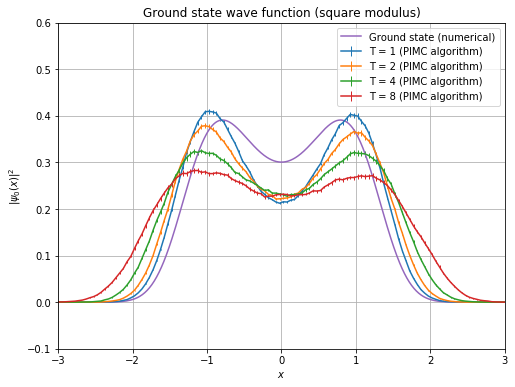

In [56]:
prefix = "exercise08-3/pimc/"
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))

# Histogram of the square modulus of the wave function.
for temp in ["1", "2", "4", "8"]:
    x_bins, h_avg, h_err = np.loadtxt(prefix + "probability_" + temp + ".dat", unpack = True)
    axes.errorbar(
        x_bins,
        h_avg,
        yerr = h_err,
        elinewidth = 1,
        label = "T = " + temp + " (PIMC algorithm)"
    )
# (The results are the same regardless of the trial wavefunction.)

axes.set_title("Ground state wave function (square modulus)")
axes.set_ylabel(r"$|\psi_0(x)|^2$")
axes.set_xlabel(r"$x$")
axes.grid(True)
axes.plot(x, (psi[0])**2, label = "Ground state (numerical)")
axes.set_xlim((-3, 3))
axes.set_ylim((-0.1, 0.6))
axes.legend()
axes.grid(True)

plt.show()

The plot shows that as the temperature is increased, the sampled wavefunction becomes broader: this is a sign that the excited states weigh more and more in the statistical ensemble.